### Доверительные интервалы для продуктовых метрик

В этой работе рассмотрены *возвращаемость (retention)* и *средняя выручка (RPU - revenue per user)*.   

Для метрик проведен анализ насколько адекватно они построены и насколько сильно они могут колебаться.

**marketing_log.csv** - данные гуглового мерчендайзер магазина

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
visits = pd.read_csv('marketing_log.csv', sep='\t')

D:\ana\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#изменение колонки с датой на время
visits['date']=pd.to_datetime(visits['date'], format='%Y-%m-%d')
visits.sort_values('date', inplace=True)

In [4]:
#сброс индексирования
visits.reset_index(drop=True, inplace=True)

Таблица **visits**:
- date - дата
- fullVisitorId - ID пользователя
- browser - браузер, с которого пользователь заходил
- deviceCategory - девайс
- transactionRevenue - сумма транзакции

In [5]:
print(visits.shape)
visits.head()

(177973, 5)


,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-08-05,377595677869445136,Chrome,desktop,NaN
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN


### Оценка числа пользователей

In [6]:
#уникальное число пользователей
day = visits.groupby('date').agg({'fullVisitorId':'nunique'}).rename(columns={'fullVisitorId': 'countID'})
day.head()

,countID
date,
2016-08-05,2492
2016-08-11,2446
2016-08-16,2619
2016-08-20,1555
2016-08-22,2352


Среднее число пользователей в день: 2355


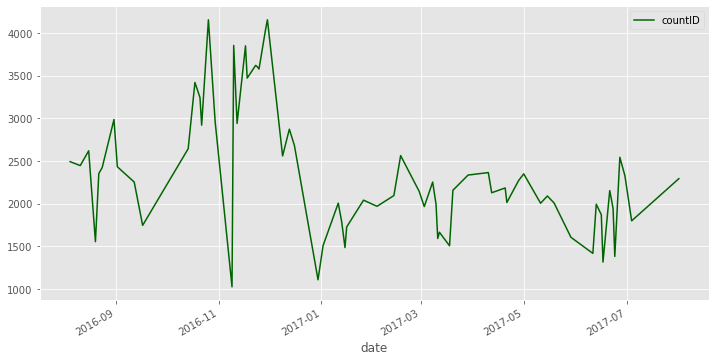

In [7]:
print(f'Среднее число пользователей в день: {int(day.countID.mean())}')
day.sort_index().plot(figsize=(12,6), color='darkgreen');

На графике посещаемости виден явно выраженное возрастание значений, которое приходится на новогодние праздники (ноябрь, декабрь). Затем кривая вернулась к более низкому уровню.  
Следовательно в работе магазина есть некоторая сезонность.

### Возвращаемость (retention)
- **retention_1** - вернулся ли пользователь после первого дня с момента посещения магазина
- **retention_7** -  вернулся ли пользователь после седьмого дня с момента посещения магазина

In [8]:
#дата первого появления пользователя
first_visits = visits.groupby('fullVisitorId').agg({'date':'min'}).rename(columns={'date': 'firstVisit'})

visits = visits.join(first_visits, on='fullVisitorId')
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,firstVisit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05


Распределение числа дней между первым и текущим посещениями пользователя.

In [9]:
visits['daysFromFirstVisit'] = (visits.date - visits.firstVisit).apply(lambda d: d.days)

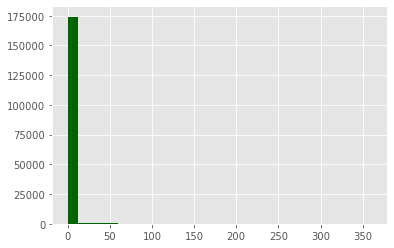

In [10]:
visits.daysFromFirstVisit.hist(bins=30, color='darkgreen');

На гистограмме видно, что большая часть пользователей приходит в магазин только один раз и больше не возвращается (разность между первой и последней датами нулевая).  
У рапсределения есть хвост, это означает, что среди пользователей есть какие-то регулярные клиенты, которые приходят в магазин даже супстя большого количества дней.

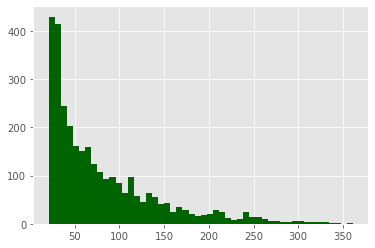

In [11]:
#пользователи, которые приходили после 20-го дня
visits[visits.daysFromFirstVisit > 20].daysFromFirstVisit.hist(bins=50, color='darkgreen');

Разность в днях для кадого пользователя между его первым и последним посещениями:

In [12]:
firsVisits = visits.groupby(['firstVisit', 'fullVisitorId']).agg({'daysFromFirstVisit':'max'}).reset_index()
firsVisits.head()

,firstVisit,fullVisitorId,daysFromFirstVisit
0,2016-08-05,1000971553963693366,0
1,2016-08-05,1006834109386002658,0
2,2016-08-05,101246539776970727,0
3,2016-08-05,1013171119747358712,0
4,2016-08-05,1015220001673280213,0


In [13]:
firsVisits.shape

(159518, 3)

В **retention_7** попадают те пользователи, у которых **daysFromFirstVisit** больше 7 дней. Подсчет их количества:

In [14]:
retention = (
    firsVisits.groupby('firstVisit').daysFromFirstVisit
    .agg([('return_7', lambda w: sum(w>=7)),
          ('total','count')]))

In [15]:
retention.head()

,return_7,total
firstVisit,,
2016-08-05,108,2492
2016-08-11,103,2413
2016-08-16,102,2543
2016-08-20,35,1532
2016-08-22,92,2234


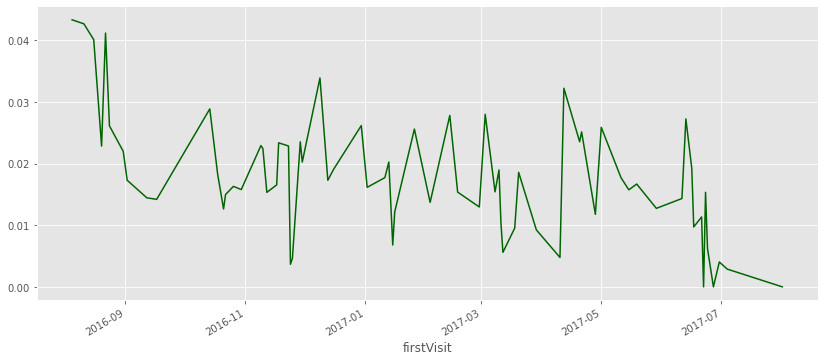

In [16]:
#retention пользователя в динамике
retention['retention'] = retention['return_7']/retention['total']
retention['retention'].plot(figsize=(14,6), color='darkgreen');

Для полученной возвращаемости можно построить доверительный интервал, по формуле для долей, полученной с помощью ЦПТ:

$$
\hat p \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} 
$$

In [17]:
alpha = 0.05

#стандартная ошибка
retention['se'] = np.sqrt(retention['retention'] * (1-retention['retention'])/retention['total'])

#границы интервалов
q = stats.norm.ppf(1-alpha/2)
retention['left'] = retention['retention'] - q * retention['se']
retention['right'] = retention['retention'] + q * retention['se']

retention.head()

,return_7,total,retention,se,left,right
firstVisit,,,,,,
2016-08-05,108,2492,0.043339,0.004079,0.035344,0.051333
2016-08-11,103,2413,0.042685,0.004115,0.034620,0.050751
2016-08-16,102,2543,0.040110,0.003891,0.032484,0.047736
2016-08-20,35,1532,0.022846,0.003817,0.015364,0.030328
2016-08-22,92,2234,0.041182,0.004204,0.032942,0.049422


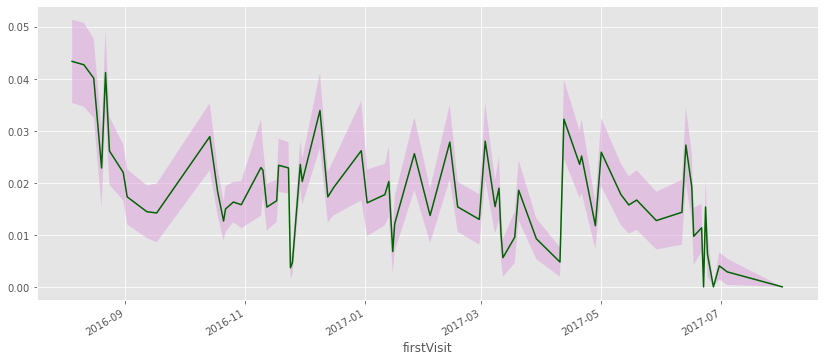

In [18]:
retention['retention'].plot(figsize=(14,6), color='darkgreen')
plt.fill_between(retention.index, retention['left'], retention['right'],
                 facecolor='plum', alpha=0.5, interpolate=True)
plt.show()

### Средний доход с пользователя (RPU)

In [19]:
#процент покупок
round(100*(1-visits['transactionRevenue'].isnull().sum()/visits.shape[0]),2)

1.31

Всего лишь 1.3% пользователей совершили покупку. Лучше оставить только тех, кто действительно совершил покупку, чтобы не искажать доверительный интервал (засчет завышения средних и дисперсий).

In [20]:
#RPU на месячной основе
visits['month'] = visits['date'].apply(lambda w: w.strftime('%Y-%m'))

purchases = visits.dropna(subset=['transactionRevenue'])
purchases.shape

(2330, 8)

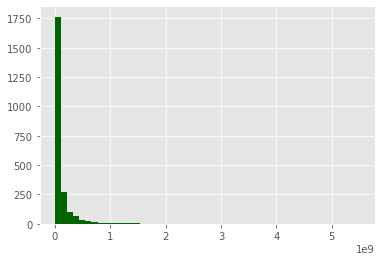

In [21]:
#распределение стоимостей покупок
purchases['transactionRevenue'].hist(bins=50, color='darkgreen');

На графике есть выбросы, которые небходимо удалить. Так как для применения ЦПТ, предполагается, что ни одна случайная величина на фоне остальных из выборки не выделяется. Для этого считается 99% квантиль и по нему делается срез.

In [22]:
q99 = purchases['transactionRevenue'].quantile(0.99)
q99

1194364900.0000002

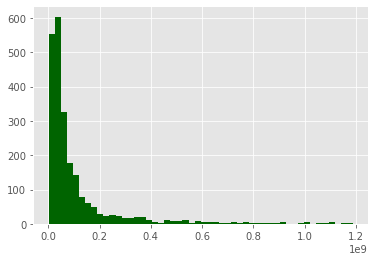

In [23]:
purchases = purchases[purchases['transactionRevenue'] < q99]
purchases['transactionRevenue'].hist(bins=50, color='darkgreen');

In [24]:
#расчет среднего, стандартного отклонения и чсила наблюдений для каждого месяца
dataPurchases = (visits.groupby('month')['transactionRevenue']
                 .agg([('rpu','mean'), ('count','count'), ('se','std')])
                 .reset_index())

In [25]:
dataPurchases.head()

,month,rpu,count,se
0,2016-08,1.403108e+08,302,2.576639e+08
1,2016-09,1.596071e+08,63,2.466225e+08
2,2016-10,1.495286e+08,154,2.847047e+08
3,2016-11,1.582393e+08,298,3.637715e+08
4,2016-12,1.078180e+08,249,2.386044e+08


Формулой для строительства доверительного интервала для среднего: 

$$
\hat \mu \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}} 
$$

In [26]:
alpha = 0.05

#границы интервалов
q = stats.norm.ppf(1-alpha/2)
dataPurchases['left'] = dataPurchases['rpu'] - q * dataPurchases['se']/np.sqrt(dataPurchases['count'])
dataPurchases['right'] = dataPurchases['rpu'] + q * dataPurchases['se']/np.sqrt(dataPurchases['count'])

dataPurchases.head()

,month,rpu,count,se,left,right
0,2016-08,1.403108e+08,302,2.576639e+08,1.112507e+08,1.693710e+08
1,2016-09,1.596071e+08,63,2.466225e+08,9.870809e+07,2.205062e+08
2,2016-10,1.495286e+08,154,2.847047e+08,1.045628e+08,1.944944e+08
3,2016-11,1.582393e+08,298,3.637715e+08,1.169375e+08,1.995410e+08
4,2016-12,1.078180e+08,249,2.386044e+08,7.818154e+07,1.374545e+08


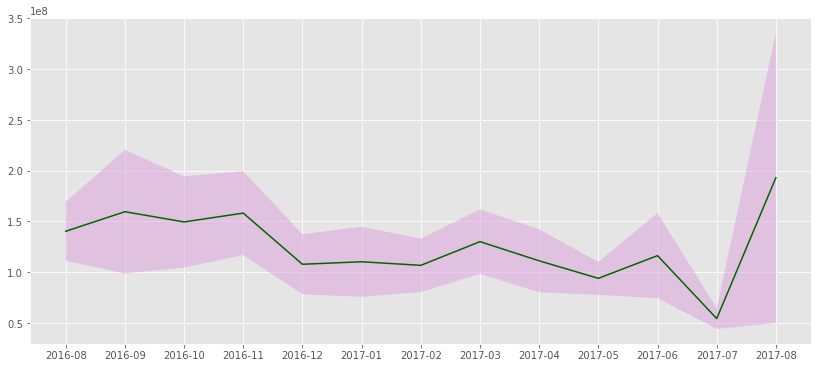

In [27]:
#динамика RPU выручки на графике:
dataPurchases['rpu'].plot(figsize=(14,6), color='darkgreen')
plt.fill_between(dataPurchases['month'], dataPurchases['left'], dataPurchases['right'],
                 facecolor='plum', alpha=0.5, interpolate=True)
plt.show()

На графике можно посмотреть, как ведет себя средняя выручка в динамике.   
В августе 2017 года дов. интервал самый широкий, так как данные за этот период собирались не за весь месяц, а за какую-то его часть. Поэтому текущая оценка будет неточная и может оказаться гораздо ниже.